In [0]:
%matplotlib inline

In [0]:
import urllib

import numpy as np
import scipy.optimize as sopt
import scipy.stats as sstats

import librosa

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition

from IPython.display import Audio

sns.set_style('whitegrid')

In [0]:
def correlate(X, Y):
    X = X - X.mean(axis=1, keepdims=True)
    X /= X.std(axis=1, keepdims=True)
    Y = Y - Y.mean(axis=1, keepdims=True)
    Y /= Y.std(axis=1, keepdims=True)
    return X @ Y.T / X.shape[1]

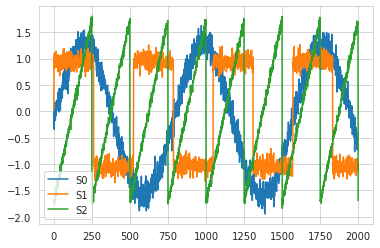

In [23]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = (2 * np.pi * time) % (2 * np.pi)

S = np.vstack([s1, s2, s3])
S += 0.1 * np.random.normal(size=S.shape)

# S = np.random.standard_t(1, size=(2,2000))
#S = np.random.laplace(size=(3,2000))


S -= S.mean(axis=1, keepdims=True)
S /= S.std(axis=1, keepdims=True)

for i, sig in enumerate(S):
    plt.plot(sig, label=f'S{i}')
plt.legend()

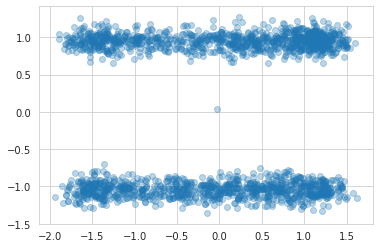

In [24]:
plt.scatter(S[0], S[1], alpha=0.3)

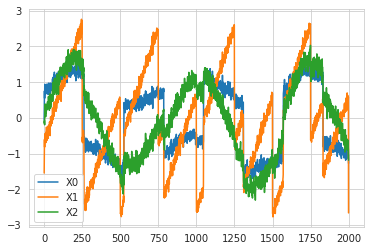

In [25]:
#A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
D = S.shape[0]

A = np.random.rand(D, D)
X = A @ S

for i, sig in enumerate(X):
    plt.plot(sig, label=f'X{i}')
plt.legend()

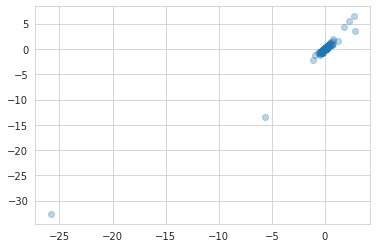

In [7]:
plt.scatter(X[0], X[1], alpha=0.3)

In [26]:
correlate(S, X)

array([[ 0.3977005 ,  0.08359641,  0.94860983],
       [ 0.94865096,  0.71179551,  0.3938135 ],
       [-0.00210486,  0.66487052,  0.03831   ]])

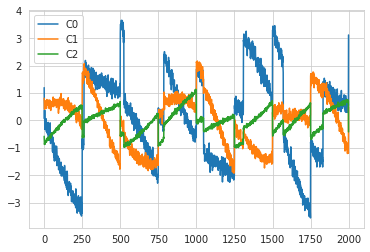

In [27]:
# Let's see what PCA does for us
# The pesky transpose comes from a different convention of interpreting matrices
# in sklearn and our course

pca = decomposition.PCA()
C = pca.fit_transform(X.T).T

for i, sig in enumerate(C):
    plt.plot(sig, label=f'C{i}')
plt.legend()

In [28]:
correlate(S, C)

array([[-0.44786591,  0.8327433 ,  0.32550686],
       [-0.81976793, -0.11156214, -0.56172452],
       [-0.38603091, -0.52582096,  0.75795281]])

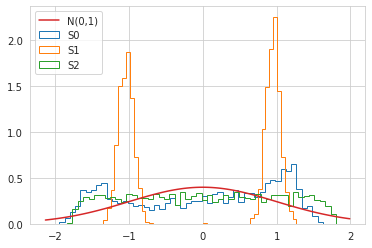

In [29]:
# Lets compare our sources to stnadard gaussian

for i, sig in enumerate(S):
    plt.hist(sig, bins=50, density=True, histtype='step', label=f'S{i}')

Xrng = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
plt.plot(Xrng, sstats.norm.pdf(Xrng), label='N(0,1)')

plt.legend()

In [0]:
def sigmoid(x):
    """A numerically stable sigmoid."""
    ret = np.empty_like(x)
    ret[x>=0] = 1 / (1 + np.exp(-x[x>=0]))
    ret[x<0] = 1 - 1 / (1 + np.exp(x[x<0]))
    return ret

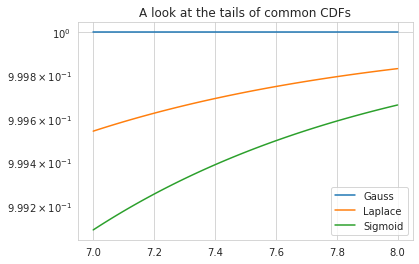

In [31]:
# Plot the CDF in the tails of some distributions.
# The gaussian one grows faster than others - it has less points
# in the tails.

rx = np.linspace(7, 8, 100)
plt.title('A look at the tails of common CDFs')
plt.semilogy(rx, sstats.norm.cdf(rx), label='Gauss')
plt.plot(rx, sstats.laplace.cdf(rx), label='Laplace')
#plt.plot(rx, sstats.cauchy.cdf(rx), label='Cauchy')
plt.plot(rx, sigmoid(rx), label='Sigmoid')
plt.legend()

In [0]:
def ica_loss(W, X, verbose=False):
    D, N = X.shape
    W = W.reshape(D, D)
    wx = W @ X

    svd_U, svd_S, svd_VH = np.linalg.svd(W)
    det_W = np.prod(svd_S)
    inv_WT = svd_U / svd_S @ svd_VH 

    log_det_W = np.log(np.abs(det_W))

    g_wx = sigmoid(wx)
    dg_wx = g_wx * (1.0 - g_wx)

    loss = np.log(dg_wx + 1e-100).sum() / N + log_det_W
    grad = (1.0 - 2.0 * g_wx) @ X.T / N + inv_WT
    if verbose:
        print(f"ICA loss: {-loss}")
    return -loss, -grad.reshape(-1)

In [33]:
# Check the gradient
print(
    sopt.check_grad(lambda x: ica_loss(x, C)[0], lambda x: ica_loss(x, C)[1], 
                    np.eye(D, D).reshape(-1)))

print(
    sopt.check_grad(lambda x: ica_loss(x, C)[0], lambda x: ica_loss(x, C)[1], 
                    np.random.rand(D, D).reshape(-1)))

8.806461524193782e-08
1.3656001841772294e-07


ICA loss: 5.044821021909626
ICA loss: 4.368303978417805
ICA loss: 4.188329060414725
ICA loss: 4.0755323696666785
ICA loss: 4.047360062966131
ICA loss: 4.04123409424049
ICA loss: 4.038743073418558
ICA loss: 4.036667607463991
ICA loss: 4.028646165964829
ICA loss: 4.027680268881386
ICA loss: 4.024479526414386
ICA loss: 4.023505288353155
ICA loss: 4.021757203847429
ICA loss: 4.017854094209127
ICA loss: 4.0128685490353275
ICA loss: 4.011464237546696
ICA loss: 4.011274107434779
ICA loss: 4.0059474270508595
ICA loss: 4.005536448714604
ICA loss: 4.000783562993103
ICA loss: 3.9960913059710097
ICA loss: 3.991838556224655
ICA loss: 3.9909068232067715
ICA loss: 3.990774338770388
ICA loss: 3.990735477049695
ICA loss: 3.9907241812193077
ICA loss: 3.9906885119767654
ICA loss: 3.9906751947676753
ICA loss: 3.9906551222469346
ICA loss: 3.9906086887504957
ICA loss: 3.9905542214374883
ICA loss: 3.990500712694145
ICA loss: 3.9904114104403936
ICA loss: 3.9903670713362125
ICA loss: 3.9903375987970957
ICA los

array([[ 0.60064823,  0.39009747,  0.70236654],
       [ 0.50472791,  0.59003189, -0.62416759],
       [-0.69195231,  0.69790315,  0.19077538]])

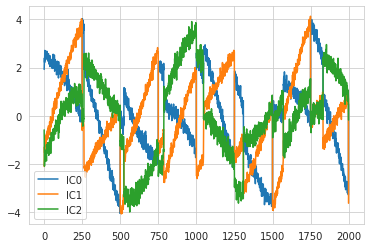

In [34]:
def ica(X, whiten=False):
    X = X - X.mean(axis=1, keepdims=True)

    if whiten:
        S = 1.0/X.shape[1] * X.dot(X.T)
        L, V = np.linalg.eig(S)
        Z = V.dot(np.diag(1.0/(np.sqrt(L)+1e-20))).dot(V.T)
        X = Z @ X

    ret = sopt.fmin_l_bfgs_b(lambda w: ica_loss(w, X, True),
                            np.eye(X.shape[0]).ravel(),
                            iprint=1, factr=1e4, maxls=1000)
    print("Opt Ret:", ret)

    W = ret[0].reshape(D, D)

    IC = W @ X
    return IC

IC = ica(X, whiten=False)

for i, sig in enumerate(IC):
    plt.plot(sig, label=f'IC{i}')
plt.legend()

correlate(S, IC)

array([[ 0.05363327,  0.99676026,  0.05993717],
       [-0.01326115,  0.03231363,  0.9993898 ],
       [ 0.99693665, -0.06985122, -0.035187  ]])

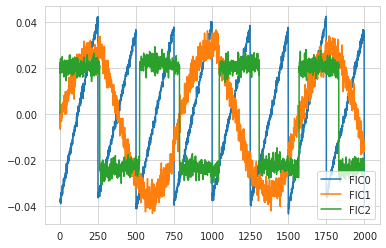

In [35]:
# Try sklearn's ICA

FIC = decomposition.FastICA().fit_transform(S.T).T

for i, sig in enumerate(FIC):
    plt.plot(sig, label=f'FIC{i}')
plt.legend()

correlate(S, FIC)

In [0]:
# Now try some audio!

In [0]:
def load_url(url):
    fname = url.split('/')[-1]
    urllib.request.urlretrieve(url, filename=fname)
    return librosa.load(fname)

src1, sr = load_url("https://upload.wikimedia.org/wikipedia/commons/a/ae/American_police_siren_i.ogg")
src2, sr2 = load_url("https://upload.wikimedia.org/wikipedia/commons/9/9a/Pleasant_Moments_Piano_Roll.ogg")
assert sr == sr2
N = min(src1.shape[0], src2.shape[0])
S = np.vstack((src1[:N], src2[:N]))
X = np.random.rand(2,2) @ S

# mic1, sr = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/rsm2_mA.wav")
# mic2, _ = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/rsm2_mB.wav")
# src1, _ = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/ssm1.wav")
# src2, _ = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/ssm2.wav")

# mic1, sr = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/rss_mA.wav")
# mic2, _ = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/rss_mB.wav")
# src1, _ = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/sss1.wav")
# src2, _ = load_url("https://cnl.salk.edu/~tewon/Blind/Demos/sss2.wav")

# mic1, sr = load_url("https://raw.githubusercontent.com/corymaklin/ida/master/mix1.wav")
# mic2, _ = load_url("https://raw.githubusercontent.com/corymaklin/ida/master/mix2.wav")
# src1, _ = load_url("https://raw.githubusercontent.com/corymaklin/ida/master/source1.wav")
# src2, _ = load_url("https://raw.githubusercontent.com/corymaklin/ida/master/source2.wav")

# N = min(mic1.shape[0], mic2.shape[0], src1.shape[0], src2.shape[0]) 
# X = np.vstack((mic1[:N], mic2[:N]))
# S = np.vstack((src1[:N], src2[:N]))h

In [0]:
N = min(src1.shape[0], src2.shape[0], 6*sr)
S = np.vstack((src1[:N], src2[:N]))
S /= S.std(axis=1, keepdims=True)
X = np.random.rand(2,2) @ S

In [43]:
correlate(S, X)

array([[0.12885103, 0.96435114],
       [0.99133096, 0.26215761]])

In [44]:
display(Audio(X[0], rate=sr))
display(Audio(X[1], rate=sr))
display(Audio(S[0], rate=sr))
display(Audio(S[1], rate=sr))

In [45]:
FIC = decomposition.FastICA(max_iter=10000).fit_transform(X.T).T
for sig in FIC:
    display(Audio(sig, rate=sr))
correlate(S, FIC)

array([[-0.99999595,  0.00287132],
       [ 0.00543017,  0.99998521]])

In [0]:
D = 2

In [48]:
IC = ica(X, whiten=True)
for sig in IC:
    display(Audio(sig, rate=sr))
correlate(S, IC)

ICA loss: 3.215474050361101
ICA loss: 2.823641806922252
ICA loss: 2.820417307907587
ICA loss: 2.819779836528788
ICA loss: 2.8197720348593247
ICA loss: 2.819755536547056
ICA loss: 2.8197376879755573
ICA loss: 2.819777038087851
ICA loss: 2.819734896578341
ICA loss: 2.8197279319519364
ICA loss: 2.8197270981880918
ICA loss: 2.8197270835413084
Opt Ret: (array([ 1.80731228, -0.05051037,  0.04825108,  1.78851246]), 2.8197270835413084, {'grad': array([ 1.95497176e-06, -3.96915449e-06, -8.97034959e-07,  7.36823625e-07]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 12, 'nit': 10, 'warnflag': 0})


array([[ 0.00484027,  0.99998319],
       [ 0.99997258, -0.00836779]])

In [49]:
C = decomposition.PCA().fit_transform(X.T).T
for sig in C:
    display(Audio(sig, rate=sr))
correlate(S, C)

array([[-0.16902905, -0.98561114],
       [-0.98517528,  0.17155053]])